TP2 Implémenter Word2vec par méthode contrastive
================================================

**Author:** Joseph Le Roux

**Date:** 2025-11-19



- AUTHOR: Joseph Le Roux
- DATE: 2025-11-19
- DESCRIPTION: Implémentation du modèle skip-gram (MLE)


## Table of Contents

- [Récupérer les données](#Rcuprer-les-donnes)
- [Nettoyage et conversion](#Nettoyage-et-conversion)
- [Jeu de données](#Jeu-de-donnes)
- [Évaluation](#valuation)
- [La boucle d&rsquo;apprentissage](#La-boucle-dapprentissage)
- [Création et en entraînement](#Cration-et-en-entranement)



# Table des matières



Dans ce TP, sur deux séances, nous implémenterons deux versions de word2vec.

1.  La première vise à maximiser la vraisemblance des contextes
    obeservés. On utilisera une distribibution exponentielle (distribution de
    Gibbs/softmax) où les potentiels sont donnés par la similarité entre mot
    central et mot contextuel calculée par produit scalaire.
2.  La deuxième est la version dérivée par Mikolov et al. pour éviter de calculer
    un softmax sur le lexique. Elle repose sur une fonction de perte alternative,
    l&rsquo;échantillonnage de contre-exemples, et la rectification par softplus.

On verra aussi le comportement des différentes versions sur deux jeux de données
différents. Le premier est un corpus relativement petit de critiques de films
tandis que le second est un corpus plus grand d&rsquo;articles de presse.



## Récupérer les données



Le code suivant télécharge les données. La partie commentée récupère le second corpus, inutile dans un premier temps pour développer votre prototype.



In [19]:
# données pour développer pendant le TP
#!wget http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip
#!unzip stanfordSentimentTreebank.zip
#!rm stanfordSentimentTreebank.zip

!wget http://mattmahoney.net/dc/text8.zip
!unzip text8
!ls

--2025-11-28 13:56:59--  http://mattmahoney.net/dc/text8.zip
Résolution de mattmahoney.net (mattmahoney.net)… 20.119.76.151
Connexion à mattmahoney.net (mattmahoney.net)|20.119.76.151|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 31344016 (30M) [application/zip]
Sauvegarde en : « text8.zip »

text8.zip           100%[===================>]  29,89M  6,28MB/s    ds 5,0s    

2025-11-28 13:57:05 (5,93 MB/s) — « text8.zip » sauvegardé [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   
__MACOSX			   TP2_word2vec_cd.ipynb
2Dimensional_Perceptron_MLP.ipynb  TP2_word2vec_cd.org
datasetSentences_clean.txt	   TP2_word2vec.ipynb
Language_Model_Etu.ipynb	   TP2_word2vec.org
old				   TP3_CNNclassif.ipynb
stanfordSentimentTreebank	   TP4_RNNtagging.ipynb
text8				   TP5_Parsing.ipynb
text8.zip			   TP5_RNNbigramTagger.ipynb
TP1_intro_pytorch.ipynb


On affiche quelques lignes du corpus:



In [60]:
#!wc stanfordSentimentTreebank/datasetSentences.txt
#!head stanfordSentimentTreebank/datasetSentences.txt

#!cat stanfordSentimentTreebank/datasetSentences.txt | cut -d$'\t' -f2,3,4,5,6 | LC_ALL=C tr -dc '\0-\177' | tr "\t" "\n"  | sed 's/\. \([A-Z]\)/. \n\1/g' | sed "s/[\.!\?():,\`';-]//g" | tr '[A-Z]' '[a-z]' > datasetSentences_clean.txt
#!head datasetSentences_clean.txt
!wc text8
!head -c 200 text8

        0  17005207 100000000 text8
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term 

## Nettoyage et conversion



La fonction suivante réalise les différentes tâches suivantes:

1.  création d&rsquo;une table wordcount qui associe à chaque mot son nombre d&rsquo;occurrences
2.  fixe une limite à la taille du vocabulaire, les mots les moins fréquents sont éliminés
3.  création d&rsquo;une table word2idx  des mots vers des identifiants entiers uniques
4.  création d&rsquo;une table idx2word symétrique
5.  Finalement crée le corpus d&rsquo;exemples sous la forme d&rsquo;un tableau d&rsquo;indices



In [61]:
import random
import math
import gc

import torch

def corpus2train(path, voc_max_size=16384):

  wordcount = {}
  lines = []

  print("counting words")
  f = open(path, 'r')
  for line in f:
    #les mots de la phrase
    tokens = line.lower().split()
    # on met à jour les comptes
    for t in tokens:
      if t in wordcount:
        wordcount[t] +=1
      else:
        wordcount[t] = 1
    lines.append(tokens)
  f.close()


  print("remove rare words")
  # your code here
  ### BEGIN SOLUTION
  wc_st = sorted(wordcount.items(), key=lambda x : -x[1])
  wc_st = wc_st[:voc_max_size]
  ### END SOLUTION

  print("building tables")
  # your code here
  ### BEGIN SOLUTION
  idx2word = [w for w,c in wc_st]
  counts = [c for w, c in wc_st]
  word2idx= { w:i for i,w in enumerate(idx2word) }
  ### END SOLUTION

  print("put all data in a single array")
  corpus = sum(lines, [])
  train = torch.zeros(len(corpus), dtype=torch.int32)
  for i in range(len(corpus)):
    train[i] = word2idx[corpus[i]] if corpus[i] in word2idx else voc_max_size
  
  train = train[train < voc_max_size]

  return(train, word2idx, idx2word, counts)

In [62]:
trainset,word2idx,idx2word,wordcount = corpus2train("text8", voc_max_size=32768)

print ("number of examples in training set:", len(trainset))
print("number of words:", len(wordcount))

counting words
remove rare words
building tables
put all data in a single array
number of examples in training set: 16370680
number of words: 32768


## Jeu de données



Un jeu de données est un objet d&rsquo;une sous-classe de `torch.utils.data.Dataset`, qui implémente deux méthodes `__len__` qui renvoie le nombre d&rsquo;exemples du jeu de données,
et `__getitem__` qui étant donné un entier *i* revoie la i<sup>e</sup> donnée du jeu.
On peut stocker des informations supplémentaires dans l&rsquo;objet. C&rsquo;est ce qu&rsquo;on fait ici.



In [63]:
#USE PYTORCH API for DATASETS
import torch

class W2VDataset(torch.utils.data.Dataset):
  def __init__(self, file, window_size=16, voc_max_size=16384):
      self.data, self.word2idx, self.idx2word, self.wordcount = corpus2train(file,voc_max_size)
      self.window_size = window_size
 
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

dataset= W2VDataset("text8", window_size=2, voc_max_size=32768)

counting words
remove rare words
building tables
put all data in a single array


In [64]:
print (len(dataset.data))
print(len(dataset.wordcount))

print(dataset.wordcount[word2idx["man"]])
visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", 
    #"enjoyable", 
    "boring", "bad", "dumb",
    #"annoying", 
    "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]
for w in visualizeWords:
  print(w, dataset.wordcount[word2idx[w]])

16370680
32768
5778
great 7770
cool 358
brilliant 205
wonderful 174
well 11537
amazing 181
worth 528
sweet 372
boring 63
bad 974
dumb 68
female 2797
male 2615
queen 1940
king 7456
man 5778
woman 1753
rain 513
snow 582
hail 70
coffee 489
tea 388


## Évaluation



on évaluera informellement le modèle appris, en affichant les vecteurs appris par les modèles sur quelques mots choisis.

L&rsquo;évaluation projette les vecteurs sur deux dimensions (en essayant de minimiser la distance entre la matrice d&rsquo;origine et la matrice projetée &ldquo;déprojetée&rdquo;, cf algorithme de la décomposition en valeur singulière), et crée le graphique sur le carnet.

Attention sur evaluate est appelée plusieurs fois dans la même cellule, les graphiques se superposent.

Attention, evaluate suppose que l&rsquo;implémentation à évaluer a deux variables de type torch.nn.Embedding, l&rsquo;une nommée V qui contient les vecteurs des mots centraux, l&rsquo;autre nommée U qui contient les vecteurs des mots contexte.

N&rsquo;oubliez pas d&rsquo;implémenter la fin de la fonction !



In [65]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
import pandas as pd


def evaluate(module, word2idx, idx2word, vistype=None):
    #finalisation des vecteurs de mots
    word_vectors = module.V.weight
    #print(word_vectors.size())
    word_vectors = word_vectors.detach().cpu()
    wv = word_vectors.numpy()

    #on teste sur ce sous-ensemble de mots (synonymes/antonymes...)
    visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]
    visualizeWords = [w for w in visualizeWords if w in word2idx]

    visualizeIdx = [word2idx[word] for word in visualizeWords]
    #print(visualizeIdx)
    visualizeVecs = wv[visualizeIdx, :]

    if vistype == 'tSNE':
      tsne = TSNE(n_components=2)
      X_tsne = tsne.fit_transform(wv)[visualizeIdx,:]
      df = pd.DataFrame(X_tsne, index=visualizeWords, columns=['x', 'y'])

      fig = plt.figure()
      ax = fig.add_subplot(1, 1, 1)

      ax.scatter(df['x'], df['y'])

      for word, pos in df.iterrows():
        ax.annotate(word, pos)

      plt.show()

    else:
      # réduction de dimension des vecteurs (en 2D pour visualisation)
      temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
      covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
      U,S,V = np.linalg.svd(covariance)
      #print(U.shape, S.shape, V.shape)
      coord = temp.dot(U[:,0:2])

      for i in range(len(visualizeWords)):
        plt.text(coord[i,0], coord[i,1], visualizeWords[i],
            bbox=dict(facecolor='green', alpha=0.1))

      plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
      plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

    #plt.savefig('word_vectors.png')


    #TODO:
    #Afficher les dix mots les plus similaires à "man"
    # en utilisant la "similarité cosinus"
    #https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html

    # your code here
    ### BEGIN SOLUTION
    cos = torch.nn.CosineSimilarity(dim=1)
    man = word2idx["man"]
    man_vec = torch.unsqueeze(word_vectors[man],0)
    sim = cos(man_vec, word_vectors)
    rank = torch.argsort(sim, descending=True)
    for i in range(10):
      print(idx2word[rank[i]], sim[rank[i]])
    ### END SOLUTION

## La boucle d&rsquo;apprentissage



In [66]:
#module : votre implémentation de w2v
#opt: l'optimisateur de descente de gradient
#dataset: une matrice NB_EXEMPLES x 2 qui contient les contextes observéss (o_idx,c_idx)
#nb_epoch, le nombre de parcours de train_set

def train(module, opt, sched, loss_module, dataset, nb_epoch, batch_size):

  dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
  ignore_index = -100
  max_index = len(dataset.wordcount)
  
  unigrams = torch.tensor(dataset.wordcount,dtype=torch.float32, device=module.device)
  total = unigrams.sum()
  unigrams = unigrams / total

  neg_correction = torch.ones_like(unigrams)
  accept = torch.ones_like(unigrams)

  #your code here : define the correction for sampling with flat unigrams (neg_correction)
  #your code here : define the correction for accepting only words that are not too frequent (accept)
  ### BEGIN SOLUTION
  neg_correction = torch.tensor(dataset.wordcount,dtype=torch.float32, device=module.device)
  neg_total = neg_correction**0.75 / total
  neg_correction = neg_correction**0.25
  neg_correction = neg_correction / neg_total
  neg_correction = neg_correction / neg_correction.mean()
  
  accept =  1e-3 / unigrams
  accept = torch.clip(accept + torch.sqrt(accept), 0.0, 1.0)
  accept /= accept.mean()
  ### END SOLUTION

  
  for epoch in range(nb_epoch):
    epoch_loss = 0

    for batch_center in dataloader:
      # your code here
      ### BEGIN SOLUTION
      batch_center_pos = torch.randint(len(dataset) - dataset.window_size, batch_center.size())
      batch_center = torch.index_select(dataset.data, 0, batch_center_pos).to(device=module.device)
      #batch_center = dataset[batch_center_pos].to(module.device)
      #batch_neighbor = (ignore_index * torch.ones_like(batch_center)).to(device=module.device)

      neighbor_offset = torch.randint(dataset.window_size, batch_center.size())
      batch_neighbor = batch_center_pos + 1 + neighbor_offset
      batch_neighbor= torch.index_select(dataset.data, 0, batch_neighbor).to(device=module.device)
      #batch_neighbor = dataset[batch_neighbor].to(module.device)

      # will sample like using unigrams
      batch_antineighbor = torch.randint(len(dataset), batch_center.size())
      batch_antineighbor = torch.index_select(dataset.data, 0, batch_antineighbor).to(device=module.device)
      #batch_antineighbor = dataset[batch_antineighbor].to(module.device)
      ### END SOLUTION
      loss = loss_module(module, batch_center, batch_neighbor, batch_antineighbor, accept, neg_correction)
      epoch_loss += loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(module.parameters(), 1.0)
      opt.step()
      opt.zero_grad()


    print(f"epoch: {epoch}\tloss: {epoch_loss/len(dataloader)}")
    sched.step(epoch_loss)
    print(sched.get_last_lr())

  evaluate(module, dataset.word2idx, dataset.idx2word)

In [67]:
class Word2Vec(torch.nn.Module):
  def __init__(self, lexicon_size, vec_size, device):
    super().__init__()
    self.V = torch.nn.Embedding(lexicon_size, vec_size)
    self.vec_size =vec_size
    self.device=device
    self.init_emb()
    self = self.to(device)

  # initialisation des embeddings autour de zero
  def init_emb(self):
    self.V.weight.data.normal_(std= 0.5 / math.sqrt(self.vec_size))
   
  # calcule les scores <w_o, w_c>
  def forward(self,idx_c, idx_o):
    # your code here
    ### BEGIN SOLUTION
    v = self.V(idx_c)
    o = self.V(idx_o)    
    ### END SOLUTION

    return torch.einsum('bi,bi->b',v,o)

man tensor(1.)
ghost tensor(0.2926)
ld tensor(0.2816)
hinayana tensor(0.2635)
aberdeen tensor(0.2634)
herculaneum tensor(0.2613)
crimean tensor(0.2560)
picts tensor(0.2527)
ridge tensor(0.2524)
homomorphisms tensor(0.2503)


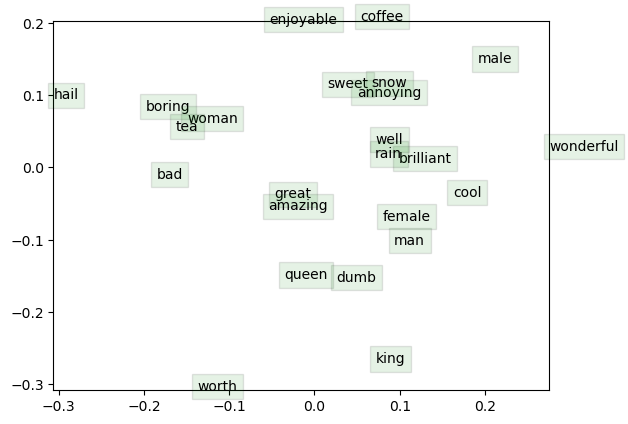

In [68]:
device =torch.device("mps")
#device =torch.device("cuda:0")
#device =torch.device("cpu")

VECTOR_SIZE=200

w2v = Word2Vec(len(dataset.idx2word), VECTOR_SIZE, device)


#on regarde les vecteurs après initialisation aléatoire
evaluate(w2v, dataset.word2idx, dataset.idx2word)

In [69]:
class CSLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  #calcule scores
  def forward(self, net, input, target, anti, accept, neg_corr):

    # your code here
    ### BEGIN SOLUTION
    pos_sim = torch.log( 1 + torch.exp(- net(input, target))) #* accept[input] * accept[target]
    neg_sim = 5 * torch.log( 1 + torch.exp(net(input, anti))) #* accept[input] * accept[anti] * neg_corr[input] * neg_corr[anti]
    ### END SOLUTION
    
    return (pos_sim + neg_sim).mean()

## Création et en entraînement



In [70]:
BATCH_SIZE = 50000

#optimizer = torch.optim.RAdam(w2v.parameters(), lr=1e-2,decoupled_weight_decay=True, weight_decay=1e-5)
optimizer = torch.optim.SGD(w2v.parameters(), lr=1e2, weight_decay=1e-5, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

loss_module = CSLoss()
train(w2v, optimizer, scheduler, loss_module, dataset, 1, BATCH_SIZE)

epoch: 0	loss: nan
[100.0]


LinAlgError: SVD did not converge

In [ ]:
# measure time
%timeit train(w2v, optimizer, scheduler, loss_module, dataset, 1, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 1, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 10, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 20, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 50, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 100, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 500, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 5000, BATCH_SIZE)